In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def treasury_futures_contracts_sequence(delivery_info):
    active_contracts=delivery_info.index.to_series()[:-1].values.reshape(-1,1)
    deferred_contracts=delivery_info.index.to_series()[1:].values.reshape(-1,1)
    notice_day=delivery_info['notice_day'].values[:-1].reshape(-1,1)
    active_deferred_contracts=np.concatenate((active_contracts, deferred_contracts,  notice_day), axis=1)
    contracts_sequence_df=pd.DataFrame(data=active_deferred_contracts, index=delivery_info['intention_day'][:-1], 
                                       columns=['active_contract', 'deferred_contract', 'notice_day'])
    return contracts_sequence_df

In [3]:
T_roll_period = pd.read_csv('../data/processed/roll_period/T_roll_period.csv', index_col='contract').astype('datetime64[ns]')
TF_roll_period = pd.read_csv('../data/processed/roll_period/TF_roll_period.csv', index_col='contract').astype('datetime64[ns]')

In [4]:
T_Close = pd.read_csv('../data/interim/raw_features/T/T_Close.csv', index_col=0, parse_dates=True)
TF_Close = pd.read_csv('../data/interim/raw_features/TF/TF_Close.csv', index_col=0, parse_dates=True)

# Calculate Spread Price

In [5]:
last_record = T_Close.index[-1]

In [6]:
T_contract_list = list(T_Close.columns)
TF_contract_list = list(TF_Close.columns)

In [7]:
wind_trading_day = pd.read_csv(r'..\data\raw\meta_data\wind_trading_day.csv', index_col='Trading_Day', parse_dates=True)

In [8]:
def convert_to_intention_day(roll_period, wind_trading_day, last_record):
    
    dominant_contract = pd.DataFrame(roll_period['end'].shift(-1))
    dominant_contract.columns = ['intention_day']
    dominant_contract = dominant_contract.astype('datetime64[ns]')
    
    num_of_nan = dominant_contract.isna().sum().values[0]
    if num_of_nan > 1:
        dominant_contract = dominant_contract.iloc[:(-1)*(num_of_nan-1), :]

    dominant_contract = dominant_contract.fillna(last_record)
    dominant_contract['notice_day'] = [wind_trading_day.loc[x:].index[1] for x in dominant_contract.iloc[:, 0]]
    dominant_contract = dominant_contract.astype(str)
    
    return dominant_contract

In [9]:
T_dominant_contract = convert_to_intention_day(T_roll_period, wind_trading_day, last_record)
TF_dominant_contract = convert_to_intention_day(TF_roll_period, wind_trading_day, last_record)

T_contracts_sequence=treasury_futures_contracts_sequence(T_dominant_contract)
TF_contracts_sequence=treasury_futures_contracts_sequence(TF_dominant_contract)

In [10]:
def find_next_contract(contract, contract_list):
    
    contract_sr = pd.Series(index=contract_list)
    
    if contract in contract_list:
        return contract_sr[contract:].index[1]
    else:
        return None

In [11]:
def get_spread_price(contracts_sequence, close, contract_list):
    
    spread_price=pd.DataFrame(columns=['active_contract', 'deferred_contract', 'active_contract_price', 'deferred_contract_price'])
    
    for i in range(len(contracts_sequence)):
        if i == 0:
            last_notice_day = close.index[0]
        else:
            last_notice_day = contracts_sequence['notice_day'][i-1]

        intention_day = contracts_sequence.index[i]
        active_contract_code = contracts_sequence['active_contract'][i]
        deferred_contract_code = contracts_sequence['deferred_contract'][i]
        
        if pd.to_datetime(intention_day) <= close.index[-1]:
            current_active_contract_price = close.loc[last_notice_day:intention_day, active_contract_code]
            current_deferred_contract_price = close.loc[last_notice_day:intention_day, deferred_contract_code]
            active_contract_code_series = pd.Series(data=active_contract_code, index=current_active_contract_price.index)
            deferred_contract_code_series = pd.Series(data=deferred_contract_code, index=current_deferred_contract_price.index)

        else:
            current_active_contract_price = close.loc[last_notice_day:, active_contract_code]
            current_deferred_contract_price = close.loc[last_notice_day:, deferred_contract_code]
            if current_active_contract_price is not None:
                active_contract_code_series = pd.Series(data=active_contract_code, index=current_active_contract_price.index)
                deferred_contract_code_series = pd.Series(data=deferred_contract_code, index=current_deferred_contract_price.index)
                
        current_data = pd.concat([active_contract_code_series, deferred_contract_code_series, 
                                current_active_contract_price, current_deferred_contract_price], axis=1)   
        current_data.columns = spread_price.columns
        spread_price = pd.concat([spread_price, current_data], axis=0)
        
    last_intention_date = pd.to_datetime(intention_day)
    
    if last_intention_date < close.index[-1]:
        
        current_contract = contracts_sequence.loc[intention_day, 'deferred_contract']
        next_contract = find_next_contract(current_contract, contract_list)
        
        latest_active_contract_price = close.loc[last_intention_date:, current_contract].iloc[1:]
        latest_deferred_contract_price = close.loc[last_intention_date:, next_contract].iloc[1:]
        active_contract_code_series = pd.Series(data=current_contract, index=latest_active_contract_price.index)
        deferred_contract_code_series = pd.Series(data=next_contract, index=latest_deferred_contract_price.index)

        current_data = pd.concat([active_contract_code_series, deferred_contract_code_series, 
                                latest_active_contract_price, latest_deferred_contract_price], axis=1)   
        current_data.columns = spread_price.columns
        
        spread_price = pd.concat([spread_price, current_data], axis=0)
        
    spread_price.index.name='Trading_Day'
    
    return spread_price

In [14]:
T_spread_price = get_spread_price(T_contracts_sequence, T_Close, T_contract_list)
TF_spread_price = get_spread_price(TF_contracts_sequence, TF_Close, TF_contract_list)

In [15]:
T_spread_price['spread_price'] = T_spread_price['active_contract_price'] - T_spread_price['deferred_contract_price']
TF_spread_price['spread_price'] = TF_spread_price['active_contract_price'] - TF_spread_price['deferred_contract_price']

In [16]:
plt.rcParams['figure.figsize'] = [25, 15]

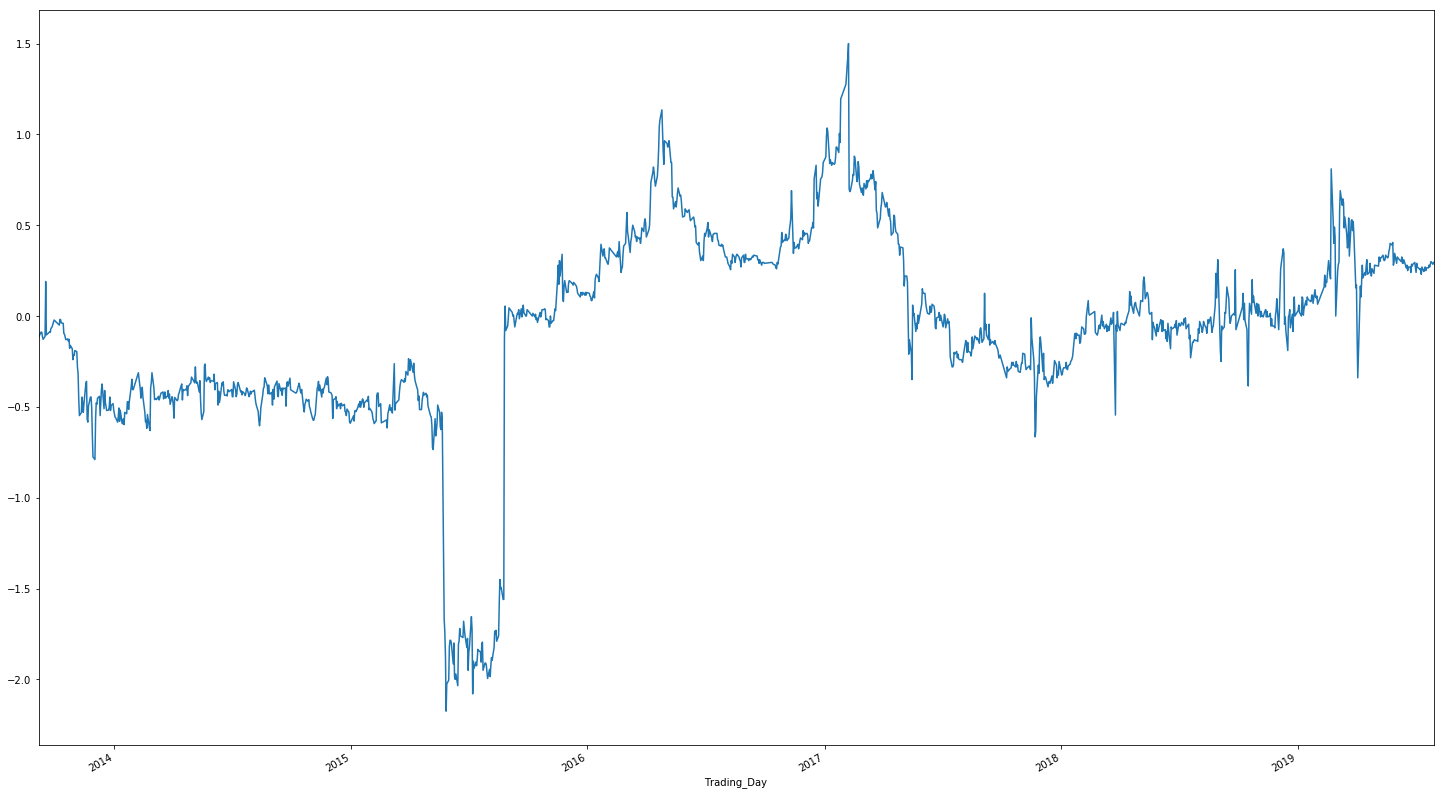

In [17]:
TF_spread_price['spread_price'].plot()

In [18]:
T_spread_price.to_csv('../data/processed/spread_price/T_spread_price.csv')
TF_spread_price.to_csv('../data/processed/spread_price/TF_spread_price.csv')

# Get Roll Period Spread Change

In [19]:
def spread_change_during_roll(spread_price, roll_period, contract_list):
    
    roll_period_for_active = roll_period.shift(-1).dropna()
    roll_period_for_active['spread_change'] = np.nan

    for active_contract in roll_period_for_active.index:      

        deferred_contract = find_next_contract(active_contract, contract_list)
        start_date = roll_period_for_active.loc[active_contract, 'start']
        end_date = roll_period_for_active.loc[active_contract, 'end']

        assert spread_price.loc[start_date, 'active_contract'] == active_contract
        assert spread_price.loc[start_date, 'deferred_contract'] == deferred_contract
        assert spread_price.loc[end_date, 'active_contract'] == active_contract
        assert spread_price.loc[end_date, 'deferred_contract'] == deferred_contract

        spread_change = spread_price.loc[end_date, 'spread_price'] - spread_price.loc[start_date, 'spread_price']
        roll_period_for_active.loc[active_contract, 'spread_change'] = spread_change
        
    return pd.DataFrame(roll_period_for_active['spread_change'])

In [21]:
def spread_change_before_roll(days, spread_price, roll_period, contract_list):
    
    roll_period_for_active = roll_period.shift(-1).dropna()
    roll_period_for_active[str(days)+'_days_before_roll'] = np.nan
    
    for active_contract in roll_period_for_active.index:

        deferred_contract = find_next_contract(active_contract, contract_list)
        start_date = roll_period_for_active.loc[active_contract, 'start']
        
        begin_date = spread_price.loc[:start_date, :].index[-1*days]
        
        spread_change = spread_price.loc[start_date, 'spread_price'] - spread_price.loc[begin_date, 'spread_price']
        roll_period_for_active.loc[active_contract, str(days)+'_days_before_roll'] = spread_change
        
    return pd.DataFrame(roll_period_for_active[str(days)+'_days_before_roll'])

In [34]:
def spread_change_before_roll_(days, spread_price, roll_period, contract_list):
    
    roll_period_for_active = roll_period.shift(-1).dropna()
    roll_period_for_active[str(days) + "d_spread_change"] = np.nan

    for active_contract in roll_period_for_active.index:

        deferred_contract = find_next_contract(active_contract, contract_list)
        # the start date of the roll period, in this case, it is the last date of the considered period
        start_date = roll_period_for_active.loc[active_contract, "start"]
        # the begin date of the considered period, days means days before the roll period
        begin_date = spread_price.loc[:start_date, :].index[-1 * days]

        spread_change = (spread_price.loc[start_date, "spread_price"] - spread_price.loc[begin_date, "spread_price"])
        roll_period_for_active.loc[active_contract, str(days) + "d_spread_change"] = spread_change

    return pd.DataFrame(roll_period_for_active[str(days) + "d_spread_change"])

In [22]:
days_list = [1, 3, 5, 10, 15, 20]

In [35]:
T_spread_change = spread_change_during_roll(T_spread_price, T_roll_period, T_contract_list)

for days in days_list:
    
    T_spread_change_before_roll = spread_change_before_roll(days, T_spread_price, T_roll_period, T_contract_list)
    T_spread_change = pd.concat([T_spread_change, T_spread_change_before_roll], axis=1)

In [25]:
TF_spread_change = spread_change_during_roll(TF_spread_price, TF_roll_period, TF_contract_list)

for days in days_list:
    
    TF_spread_change_before_roll = spread_change_before_roll(days, TF_spread_price, TF_roll_period, TF_contract_list)
    TF_spread_change = pd.concat([TF_spread_change, TF_spread_change_before_roll], axis=1)
    
TF_spread_change

,spread_change,1_days_before_roll,3_days_before_roll,5_days_before_roll,10_days_before_roll,15_days_before_roll,20_days_before_roll
contract,,,,,,,
TF1312,-0.032,0.0,0.102,-0.128,-0.232,-0.318,-0.346
TF1403,-0.218,0.0,-0.008,-0.006,0.102,0.186,0.168
TF1406,-0.156,0.0,-0.090,-0.034,0.014,0.092,0.090
TF1409,-0.066,0.0,-0.026,-0.012,-0.044,-0.006,-0.064
TF1412,-0.046,0.0,-0.028,-0.022,-0.074,-0.076,-0.136
TF1503,-0.074,0.0,-0.002,-0.002,0.048,0.046,-0.016
TF1506,-0.010,0.0,-0.060,-0.110,-0.090,-0.150,-0.245
TF1509,0.160,0.0,0.050,0.000,0.280,0.065,0.455
TF1512,0.305,0.0,0.040,0.030,0.040,0.035,-0.005


In [26]:
T_spread_change.to_csv('../data/interim/features/spread_change/T_spread_change.csv')
TF_spread_change.to_csv('../data/interim/features/spread_change/TF_spread_change.csv')